In [1]:
import numpy as np
import pandas as pd
import sys
import pickle
sys.path.append("../../")
sys.path.append("../")
import spacy
from src.loader import TextLoader
from src.purifier import Purifier
from tqdm import tqdm
from pathlib import Path
import torch

from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


c:\Users\Jurek\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Jurek\anaconda3\envs\nlp\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
enc = LabelEncoder()

In [3]:
module_path = Path.cwd().parent.parent
if module_path not in sys.path:
    sys.path.insert(0, str(module_path))
path = Path(module_path / "data" / "train_v1_no_predictionstring.xz")
data = pd.read_csv(path, compression="xz")
data = data[["discourse_text", "discourse_type"]]
data.head()

,discourse_text,discourse_type
0,Modern humans today are always on their phone....,Lead
1,They are some really bad consequences when stu...,Position
2,Some certain areas in the United States ban ph...,Evidence
3,When people have phones they know about certai...,Evidence
4,Driving is one of the way how to get around. P...,Claim


In [28]:
data = data.sample(frac = 1)

In [30]:
data.head()

,discourse_text,discourse_type
143305,You won't be confused on what decision you sho...,Claim
108965,I think it would be a great idea to have the s...,Position
56125,Have you ever heard of the man on the moon Wel...,Lead
36069,Yes students have homework to do so we can hav...,Rebuttal
80793,This is a great idea but if we could find a wa...,Evidence


In [31]:
def count_label(df, labels):
    label_count_dict = {}
    labeled_df_dict = {}
    for label in labels:
        label_df = df[df['discourse_type']==label]
        label_count_dict[label] = len(label_df)
        labeled_df_dict[label] = label_df
    return label_count_dict, labeled_df_dict

def oversampling(df, labels, amount_for_class = 1000):
    new_df = pd.DataFrame()
    label_count, labeled_df_dict = count_label(df, labels)
    print(label_count)
    for label, count in label_count.items():
        print(label)
        lb_df = labeled_df_dict[label]
        if count < amount_for_class:
            while len(lb_df) < amount_for_class:
                row = labeled_df_dict[label].sample()
                lb_df = pd.concat([lb_df, row])
                #lb_df.loc[len(new_df)] = [row.values[0][0], row.values[0][1]]
        new_df = pd.concat([new_df, lb_df])
    new_df = new_df.sample(frac=1).reset_index(drop=True)
    return new_df

def undersampling(df, labels, amount_for_class = 1000):
    new_df = pd.DataFrame()
    label_count, labeled_df_dict = count_label(df, labels)
    for label, count in label_count.items():
        lb_df = pd.DataFrame()
        if count < amount_for_class:
            lb_df = labeled_df_dict[label]
            new_df = pd.concat([new_df, lb_df])
        else:
            while len(lb_df) < amount_for_class:
                row = labeled_df_dict[label].sample()
                lb_df = pd.concat([lb_df, row])
            new_df = pd.concat([new_df, lb_df])
    return new_df

In [32]:
count_label(data, ['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement', 'Counterclaim', 'Rebuttal'])

({'Lead': 9303,
  'Position': 15415,
  'Evidence': 45691,
  'Claim': 50197,
  'Concluding Statement': 13503,
  'Counterclaim': 5813,
  'Rebuttal': 4334},
 {'Lead':                                            discourse_text discourse_type
  56125   Have you ever heard of the man on the moon Wel...           Lead
  25482   Hello. My name is Luke. And I was in the Seago...           Lead
  7319    People are finally opening their eyes to the w...           Lead
  54465   You think technology can read emotional face e...           Lead
  4646    Every other day a person die in a car accident...           Lead
  ...                                                   ...            ...
  123617  What if you missed a day of class and when you...           Lead
  62971   for some students say that what's the point wh...           Lead
  133566  Have you ever needed advice but did not know w...           Lead
  126158  In some schools think that attend classes at h...           Lead
  53605   Is 

In [55]:
data = undersampling(data, ['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement', 'Counterclaim', 'Rebuttal'], 15000)

In [56]:
X = data["discourse_text"]

In [57]:
new_X = []
nlp = spacy.load("en_core_web_lg")
for i, x in enumerate(X):
    token = nlp(x)
    new_X.append(token.vector)

In [ ]:
y = data["discourse_type"]

In [ ]:
y_encoded = enc.fit_transform(y)

In [ ]:
y_encoded

array([0, 5, 4, ..., 0, 0, 0])

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(new_X, y_encoded, test_size=0.1, random_state=42)

In [ ]:
len(new_X)

144256

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y_encoded, test_size=0.15, random_state=2137)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=2/3, random_state=2137)

In [ ]:
print(len(X_train), len(X_test), len(X_val))

122617 7213 14426


In [ ]:
class DiscourseClassifier():
    def __init__(self):
        # hyperparameters
        self.subsample = 0.7
        self.colsample_bytree = 0.7
        self.gamma = 0
        self.reg_lambda = 0

        self.model = self.create_model()

    def create_model(self):
        clf = XGBClassifier(random_state=42, seed=2, colsample_bytree=self.colsample_bytree, subsample=self.subsample, gamma=self.gamma, reg_lambda=self.reg_lambda)
        return clf
    
    def fit(self, X_train, y_train, eval_set):
        self.model.fit(X_train, y_train, eval_set=eval_set)

    def predict(self, X_test):
        return self.model.predict(X_test)

In [ ]:
discource_clf = DiscourseClassifier()

discource_clf.fit(X_train, y_train, [(X_val, y_val)])

y_pred = discource_clf.predict(X_test)

c:\Users\Jurek\anaconda3\envs\nlp\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:36:28] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.72593
[1]	validation_0-mlogloss:1.59151
[2]	validation_0-mlogloss:1.49937
[3]	validation_0-mlogloss:1.43282
[4]	validation_0-mlogloss:1.37878
[5]	validation_0-mlogloss:1.33519
[6]	validation_0-mlogloss:1.30201
[7]	validation_0-mlogloss:1.27280
[8]	validation_0-mlogloss:1.24782
[9]	validation_0-mlogloss:1.22743
[10]	validation_0-mlogloss:1.20975
[11]	validation_0-mlogloss:1.19434
[12]	validation_0-mlogloss:1.18098
[13]	validation_0-mlogloss:1.16854
[14]	validation_0-mlogloss:1.15662
[15]	validation_0-mlogloss:1.14679
[16]	validation_0-mlogloss:1.13803
[17]	validation_0-mlogloss:1.13017
[18]	validation_0-mlogloss:1.12217
[19]	validation_0-mlogloss:1.11451
[20]	validation_0-ml

In [ ]:
accuracy_score(y_test, y_pred)

0.6667128795230833

In [ ]:
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
y_pred

array([0, 3, 0, ..., 0, 0, 3])

In [ ]:
enc.inverse_transform([0,1,2,3,4,5,6])

array(['Claim', 'Concluding Statement', 'Counterclaim', 'Evidence',
       'Lead', 'Position', 'Rebuttal'], dtype=object)

weighted 0.6425729363140874
micro 0.6667128795230833
macro 0.46759199511316935
matthews_corrcoef 0.536482390165421


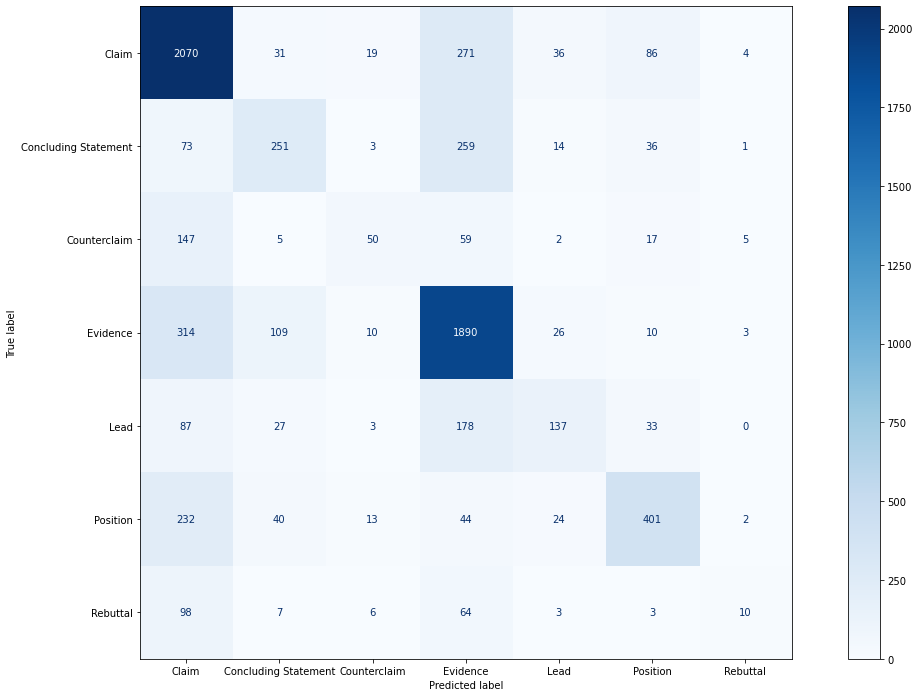

In [ ]:
print('weighted', f1_score(y_test, y_pred, average='weighted'))
print('micro', f1_score(y_test, y_pred, average='micro'))
print('macro', f1_score(y_test, y_pred, average='macro'))
print('matthews_corrcoef', matthews_corrcoef(y_test, y_pred))

fig = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                               labels=[0,1,2,3,4,5,6], 
                                               display_labels = ['Claim', 'Concluding Statement', 'Counterclaim', 'Evidence', 'Lead', 'Position', 'Rebuttal'],
                                               cmap=plt.cm.Blues,
                                               )
fig = fig.ax_.get_figure() 
fig.set_figwidth(20)
fig.set_figheight(12)